## Download and 

In [ ]:
# These are all the modules I'll be using later. 
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

import pandas as pd
import urllib
import cPickle as pickle
from PIL import Image
import scipy.io as sio
import scipy.io
import h5py
import random
import tensorflow as tf
from sklearn.cross_validation import train_test_split as ttsplit
import math as math
import pylab as 

In [2]:
url = 'http://ufldl.stanford.edu/housenumbers/'
last_percent_reported = None

def download_progress(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def download_data(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    print('Failed to verify ' + filename + 'Can you get to it with a browser?')
  return filename

train_filename = download_data('train.tar.gz', 404141560)
test_filename = download_data('test.tar.gz', 276555967)
extra_filename = download_data('extra.tar.gz', 1955489752)

cropped_train_filename = download_data('train_32x32.mat', 182040794)
cropped_test_filename = download_data('test_32x32.mat', 64275384)
cropped_extra_filename = download_data('extra_32x32.mat', 1329278602)

Found and verified train.tar.gz
Found and verified test.tar.gz
Found and verified extra.tar.gz
Found and verified train_32x32.mat
Found and verified test_32x32.mat
Found and verified extra_32x32.mat


In [3]:
def extract_data(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]
  if os.path.isdir(root) and not force:
    print('%s already present - Skipping extra of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  return root

train_folders = extract_data(train_filename)
test_folders = extract_data(test_filename)
extra_folders = extract_data(extra_filename)

train already present - Skipping extra of train.tar.gz.
test already present - Skipping extra of test.tar.gz.
extra already present - Skipping extra of extra.tar.gz.


---

Samples from cropped training dataset


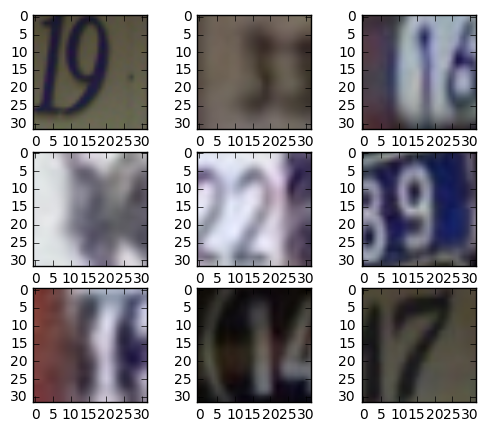

In [4]:
print("Samples from cropped training dataset")

cropped_train_dataset = scipy.io.loadmat(cropped_train_filename)

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(6,5))
ax1.imshow(cropped_train_dataset['X'][:,:,:,1])
ax2.imshow(cropped_train_dataset['X'][:,:,:,10])
ax3.imshow(cropped_train_dataset['X'][:,:,:,20])
ax4.imshow(cropped_train_dataset['X'][:,:,:,30])
ax5.imshow(cropped_train_dataset['X'][:,:,:,40])
ax6.imshow(cropped_train_dataset['X'][:,:,:,50])
ax7.imshow(cropped_train_dataset['X'][:,:,:,60])
ax8.imshow(cropped_train_dataset['X'][:,:,:,70])
ax9.imshow(cropped_train_dataset['X'][:,:,:,80])
plt.show()

In [5]:
# I used udacity's discussion(https://discussions.udacity.com/t/how-to-deal-with-mat-files/160657/5) for reference.

class DigitStructFile:
  def __init__(self, inf):
    self.inf = h5py.File(inf, 'r')
    self.digitStructName = self.inf['digitStruct']['name']
    self.digitStructBbox = self.inf['digitStruct']['bbox']

# getName returns the 'name' string for for the n(th) digitStruct. 
  def getName(self,n):
    return ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]].value])

# bboxHelper handles the coding difference when there is exactly one bbox or an array of bbox. 
  def bboxHelper(self,attr):
    if (len(attr) > 1):
      attr = [self.inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
    else:
      attr = [attr.value[0][0]]
    return attr

# getBbox returns a dict of data for the n(th) bbox. 
  def getBbox(self,n):
    bbox = {}
    bb = self.digitStructBbox[n].item()
    bbox['height'] = self.bboxHelper(self.inf[bb]["height"])
    bbox['label'] = self.bboxHelper(self.inf[bb]["label"])
    bbox['left'] = self.bboxHelper(self.inf[bb]["left"])
    bbox['top'] = self.bboxHelper(self.inf[bb]["top"])
    bbox['width'] = self.bboxHelper(self.inf[bb]["width"])
    return bbox

  def getDigitStructure(self,n):
    s = self.getBbox(n)
    s['name']=self.getName(n)
    return s

# getAllDigitStructure returns all the digitStruct from the input file.     
  def getAllDigitStructure(self):
    return [self.getDigitStructure(i) for i in range(len(self.digitStructName))]

# Return a restructured version of the dataset (one structure by boxed digit).
#
#   Return a list of such dicts :
#      'filename' : filename of the samples
#      'boxes' : list of such dicts (one by digit) :
#          'label' : 1 to 9 corresponding digits. 10 for digit '0' in image.
#          'left', 'top' : position of bounding box
#          'width', 'height' : dimension of bounding box
#
# Note: We may turn this to a generator, if memory issues arise.
    def getAllDigitStructure_ByDigit(self):
        pictDat = self.getAllDigitStructure()
        result = []
        structCnt = 1
        for i in range(len(pictDat)):
            item = { 'filename' : pictDat[i]["name"] }
            figures = []
            for j in range(len(pictDat[i]['height'])):
               figure = {}
               figure['height'] = pictDat[i]['height'][j]
               figure['label']  = pictDat[i]['label'][j]
               figure['left']   = pictDat[i]['left'][j]
               figure['top']    = pictDat[i]['top'][j]
               figure['width']  = pictDat[i]['width'][j]
               figures.append(figure)
            structCnt = structCnt + 1
            item['boxes'] = figures
            result.append(item)
        return result

In [6]:
train_folders = 'train'
test_folders = 'test'
extra_folders = 'extra'

In [ ]:
f = os.path.join(train_folders, 'digitStruct.mat')
dsf = DigitStructFile(f)
train_dataset = dsf.getAllDigitStructure_ByDigit()

In [ ]:
f = os.path.join(test_folders, 'digitStruct.mat')
dsf = DigitStructFile(f)
test_dataset = dsf.getAllDigitStructure_ByDigit()

In [ ]:
f = os.path.join(extra_folders, 'digitStruct.mat')
dsf = DigitStructFile(f)
extra_dataset = dsf.getAllDigitStructure_ByDigit()

Let's save the data for later reuse:

In [ ]:
def maybe_pickle(dataset, folders, force=False):
  set_filename = folders + '.pickle'
  if os.path.exists(set_filename) and not force:
    print('%s already present - Skipping pickling.' % set_filename)
  else:
    print('Pickling %s.' % set_filename)
    try:
      with open(set_filename, 'wb') as f:
        pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      print('Seve', set_filename, '!')
    except Exception as e:
      print('Unable to save data to', set_filename, ':', e)
    
train_pickle = maybe_pickle(train_dataset, train_folders)
test_pickle = maybe_pickle(test_dataset, test_folders)
extra_pickle = maybe_pickle(extra_dataset, extra_folders)